In [106]:
import xarray as xr
import pandas as pd

from pathlib import Path
from scipy.ndimage import label, maximum_filter
from scipy.interpolate import griddata

import sys, os, re
import numpy as np      
from netCDF4 import Dataset    
from scipy.spatial import cKDTree

import matplotlib.pyplot as plt       
from matplotlib.patches import Patch

from pyproj import Geod
import cartopy.crs as ccrs                              
import cartopy.feature as cfeature         
import cartopy.io.shapereader as shpreader 

from matplotlib.colors import ListedColormap, BoundaryNorm

from datetime import datetime, timedelta

# WS extent

In [60]:
CONTEXT_LAT_MIN = 5
CONTEXT_LAT_MAX = 20
CONTEXT_LON_MIN = -20
CONTEXT_LON_MAX = -4

# Data loading

## Load core

In [61]:
def load_core(t):

    year   = int(t["year"])
    month  = f"{int(t['month']):02d}"
    day    = f"{int(t['day']):02d}"
    hour   = f"{int(t['hour']):02d}"
    minute = f"{int(t['minute']):02d}"

    if year <= 2024:

        base = f"/gws/nopw/j04/cocoon/SSA_domain/ch9_wavelet/{year}/{month}"
        fname = f"{year}{month}{day}{hour}{minute}.nc"
        path = os.path.join(base, fname)

        with Dataset(path) as ds:
            cores = ds["cores"][0]

            Pmax_lat = ds["max_lat"][:]
            Pmax_lon = ds["max_lon"][:]

        geo = np.load("/gws/nopw/j04/cocoon/SSA_domain/lat_lon_2268_2080.npz")
        lons = geo["lon"]
        lats = geo["lat"]

    else:

        base = f"/gws/ssde/j25b/swift/rt_cores/{year}/{month}/{day}/{hour}{minute}"
        fname = f"Convective_struct_extended_{year}{month}{day}{hour}{minute}_000.nc"
        path = os.path.join(base, fname)

        with Dataset(path) as ds:
            cores = ds["cores"][:]

            Pmax_lat = ds["Pmax_lat"][:]
            Pmax_lon = ds["Pmax_lon"][:]

        geo = Dataset(
            "/gws/ssde/j25b/swift/rt_cores/geoloc_grids/"
            "nxny2268_2080_nxnyds164580_blobdx0.04491576_arean41_n27_27_79.nc"
        )
        lons = geo["lons_mid"][:]
        lats = geo["lats_mid"][:]
        geo.close()

    # ensure 1D arrays for matching
    Pmax_lat = np.asarray(Pmax_lat).ravel()
    Pmax_lon = np.asarray(Pmax_lon).ravel()

    return cores, lats, lons, Pmax_lat, Pmax_lon

## Load RoA

In [62]:
def load_roa(t):

    year   = f"{int(t['year']):04d}"
    month  = f"{int(t['month']):02d}"
    day    = f"{int(t['day']):02d}"
    hour   = f"{int(t['hour']):02d}"
    minute = f"{int(t['minute']):02d}"

    base = Path("/gws/ssde/j25b/swift/RoA")

    t0 = datetime(int(year), int(month), int(day),
                  int(hour), int(minute))
    t1 = t0 + timedelta(minutes=15)

    # Try MSG4 first, then MSG3
    candidates = []
    for sat in ["MSG4", "MSG3"]:
        fname = (
            f"{sat}{t0:%Y%m%d}"
            f"-S{t0:%H%M}"
            f"-E{t1:%H%M}.nc"
        )
        candidates.append(base / year / month / fname)

    path = next((p for p in candidates if p.exists()), None)

    if path is None:
        print("No RoA file found for this time")
        return None, None, None

    with Dataset(path) as ds:

        lat = ds.variables["latitude"][:]
        lon = ds.variables["longitude"][:]

        var = ds.variables["posterior_mean"]
        roa = var[:]

        if hasattr(var, "scale_factor"):
            scale = var.scale_factor
            offset = getattr(var, "add_offset", 0.0)
            roa = roa * scale + offset

        roa = np.ma.filled(roa, np.nan)

    lons, lats = np.meshgrid(lon, lat)

    return roa, lats, lons


# Load data for comparison

## Choose time

In [63]:
t = dict(year=2020, month=7, day=5, hour=12, minute=15)

## Load both data

In [64]:
data_core, lats_core, lons_core, Pmax_lat, Pmax_lon = load_core(t)
data_roa, lats_roa, lons_roa = load_roa(t)

## Plotting and overlay (threshold 0 for both)

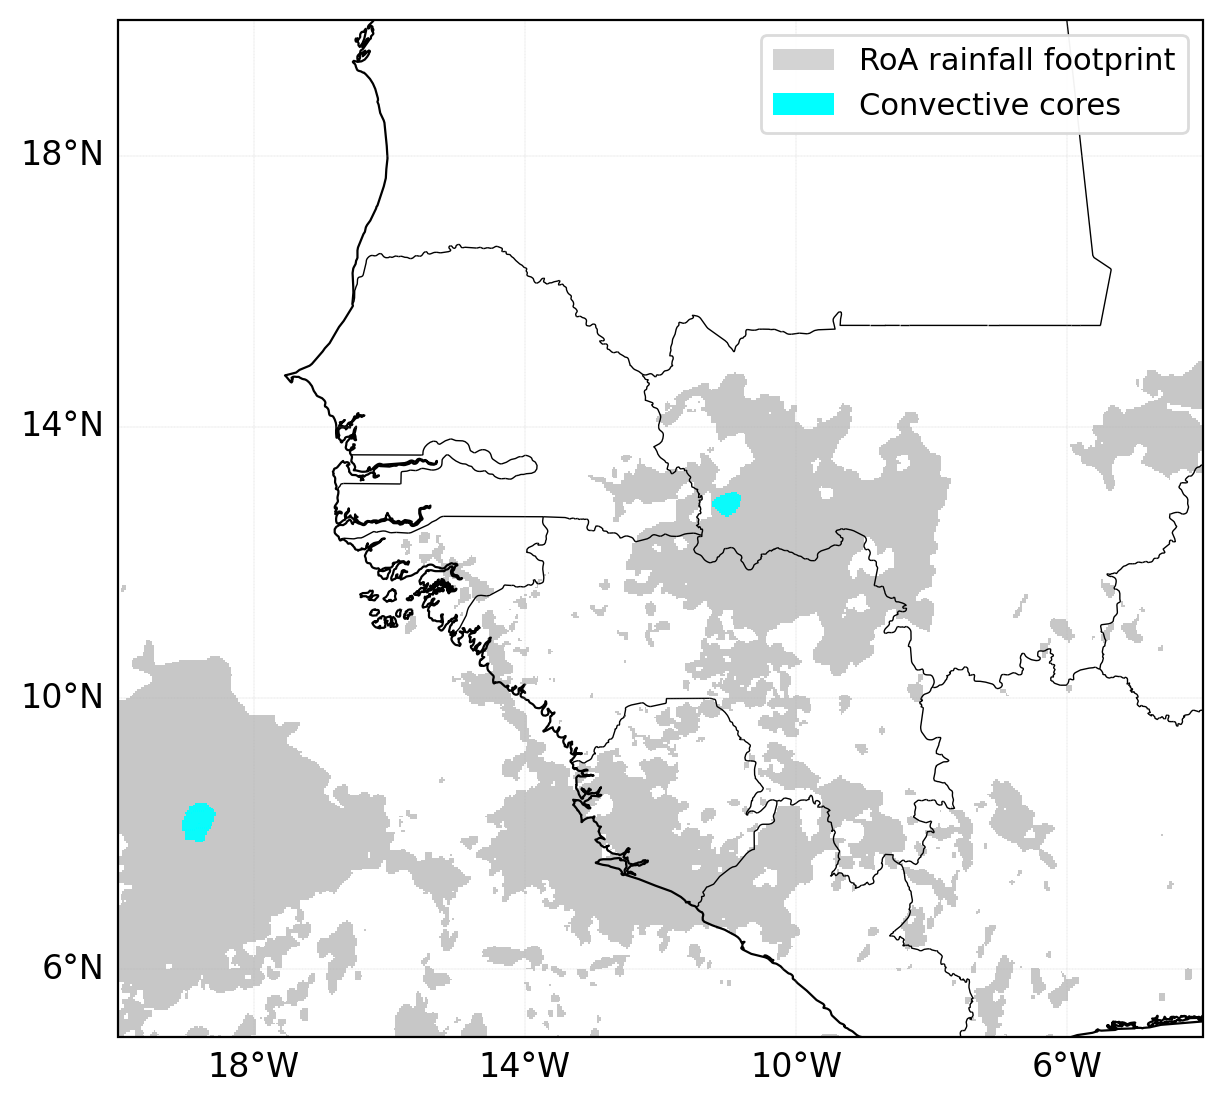

In [ ]:
mask_roa  = np.where(data_roa > 0, 1, np.nan)
mask_core = np.where(data_core > 0, 1, np.nan)

proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(7, 7), dpi=200)
ax = plt.axes(projection=proj)

ax.coastlines(resolution="10m", linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)

ax.set_extent(
    [CONTEXT_LON_MIN, CONTEXT_LON_MAX,
     CONTEXT_LAT_MIN, CONTEXT_LAT_MAX],
    crs=proj
)

gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.1,
                  xlocs=np.arange(-18, 6, 4),
                  ylocs=np.arange(6, 20, 4))
d
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {"size": 12}
gl.ylabel_style = {"size": 12}


# RoA rainfall footprint
ax.pcolormesh(
    lons_roa,
    lats_roa,
    mask_roa,
    shading="nearest",
    cmap=ListedColormap(["#c7c7c7"]),
    alpha=1,
    transform=proj
)

# Convective cores
ax.pcolormesh(
    lons_core,
    lats_core,
    mask_core,
    shading="nearest",
    cmap=ListedColormap(["cyan"]),
    alpha=0.95,
    transform=proj
)

legend_elements = [
    Patch(facecolor="lightgrey", edgecolor="none", label="RoA rainfall footprint"),
    Patch(facecolor="cyan", edgecolor="none", label="Convective cores"),
]

ax.legend(
    handles=legend_elements,
    loc="upper right",
    framealpha=0.95,
    edgecolor="0.85",
    fontsize=11
)

plt.show()

# Domain cropping

## Utilities for cropping

In [76]:
class GeoGrid:

    def __init__(
        self,
        lats,
        lons,
        lat_min,
        lat_max,
        lon_min,
        lon_max,
        fill_value=-999.999
    ):

        self.fill_value = fill_value

        self.lats, self.lons, self.area, self.y0, self.y1, self.x0, self.x1 = \
            self._crop_with_area(
                lats, lons,
                lat_min, lat_max,
                lon_min, lon_max
            )

        self.Ny, self.Nx = self.lats.shape

        points = np.column_stack([
            self.lats.ravel(),
            self.lons.ravel()
        ])

        self.tree = cKDTree(points)


    def _crop_with_area(
        self,
        lats,
        lons,
        lat_min,
        lat_max,
        lon_min,
        lon_max
    ):

        lats_nan = np.where(lats == self.fill_value, np.nan, lats)
        lons_nan = np.where(lons == self.fill_value, np.nan, lons)

        mask = (
            (lats_nan >= lat_min) &
            (lats_nan <= lat_max) &
            (lons_nan >= lon_min) &
            (lons_nan <= lon_max)
        )

        rows = np.where(mask.any(axis=1))[0]
        cols = np.where(mask.any(axis=0))[0]

        y0, y1 = rows[0], rows[-1]
        x0, x1 = cols[0], cols[-1]

        lats_crop = lats[y0:y1+1, x0:x1+1]
        lons_crop = lons[y0:y1+1, x0:x1+1]

        R = 6371.0

        lat_rad = np.deg2rad(lats_crop)
        lon_rad = np.deg2rad(lons_crop)

        dlat = np.gradient(lat_rad, axis=0)
        dlon = np.gradient(lon_rad, axis=1)

        dy = R * dlat
        dx = R * np.cos(lat_rad) * dlon

        area = np.abs(dx * dy)

        return lats_crop, lons_crop, area, y0, y1, x0, x1


    def crop(self, field):
        return field[self.y0:self.y1+1, self.x0:self.x1+1]


    def query(self, lat, lon):
        _, idx = self.tree.query([lat, lon])
        return np.unravel_index(idx, (self.Ny, self.Nx))

    def query_many(self, lat, lon):
        pts = np.column_stack([lat, lon])
        _, idx = self.tree.query(pts)
        return np.unravel_index(idx, (self.Ny, self.Nx))


## Crop RoA and core data

In [77]:
extent = (
    CONTEXT_LAT_MIN, CONTEXT_LAT_MAX,
    CONTEXT_LON_MIN, CONTEXT_LON_MAX
)

grid_core = GeoGrid(lats_core, lons_core, *extent)
grid_roa  = GeoGrid(lats_roa,  lons_roa,  *extent)

# crop data
data_core = grid_core.crop(data_core)
data_roa  = grid_roa.crop(data_roa)

# use cropped coordinates from grid
lats_core = grid_core.lats
lons_core = grid_core.lons

lats_roa  = grid_roa.lats
lons_roa  = grid_roa.lons

In [85]:
assert data_core.shape == lats_core.shape == lons_core.shape 
assert data_roa.shape == lats_roa.shape == lons_roa.shape 

In [89]:
print("Core shape:", data_core.shape)
print("RoA shape :", data_roa.shape)

if data_core.shape != data_roa.shape:
    print("Grids differ → interpolation required.")

Core shape: (532, 578)
RoA shape : (555, 593)
Grids differ → interpolation required.


## Plot to check nothing is broken

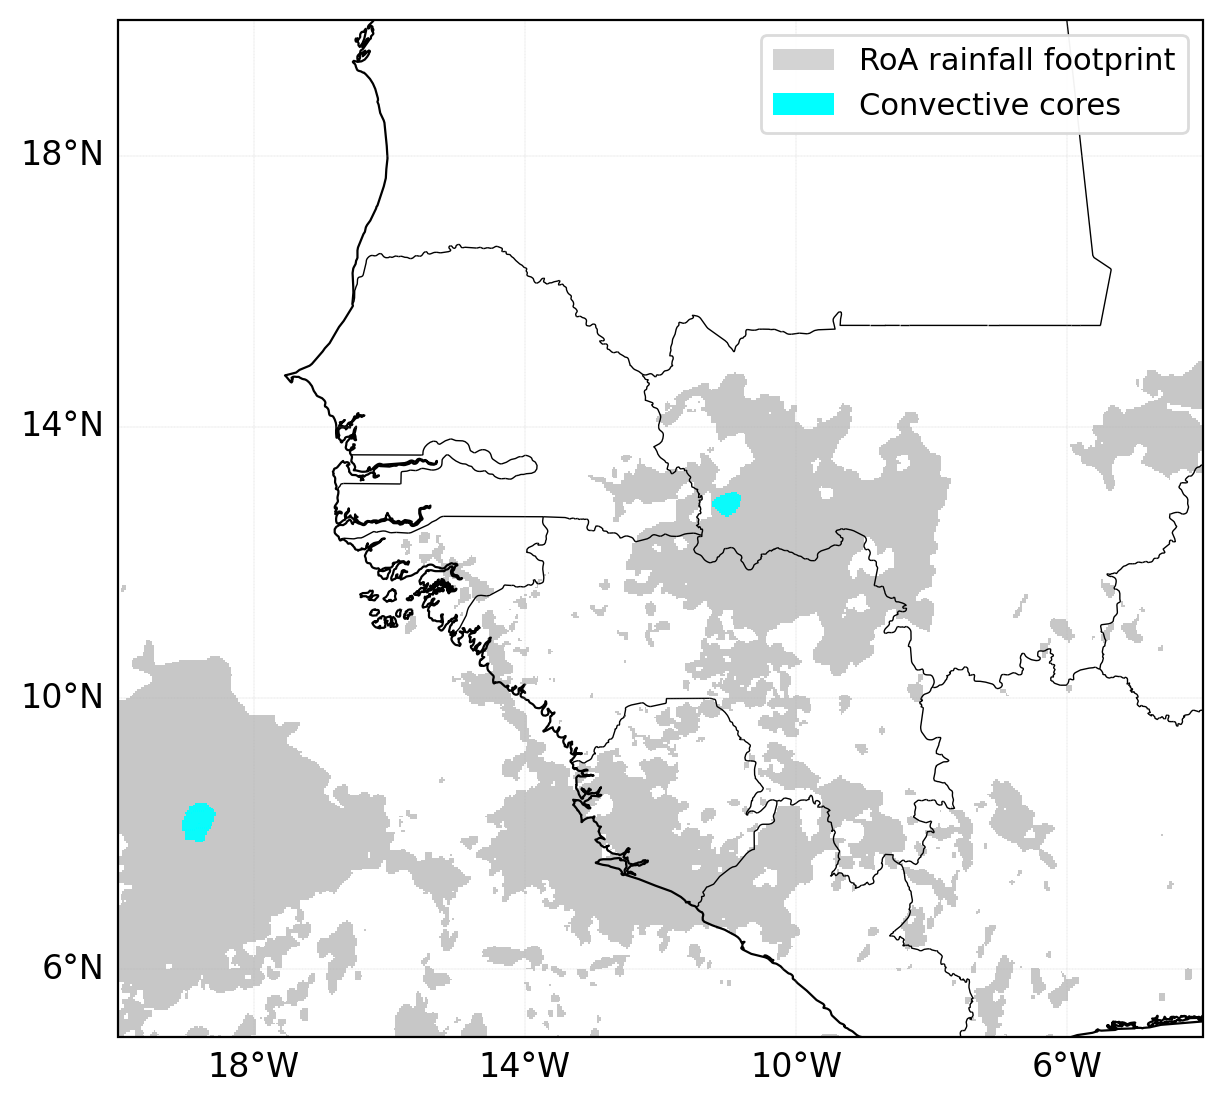

In [99]:
mask_roa  = np.where(data_roa > 0, 1, np.nan)
mask_core = np.where(data_core > 0, 1, np.nan)

proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(7, 7), dpi=200)
ax = plt.axes(projection=proj)

ax.coastlines(resolution="10m", linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)

ax.set_extent(
    [CONTEXT_LON_MIN, CONTEXT_LON_MAX,
     CONTEXT_LAT_MIN, CONTEXT_LAT_MAX],
    crs=proj
)

gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.1,
                  xlocs=np.arange(-18, 6, 4),
                  ylocs=np.arange(6, 20, 4))

gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {"size": 12}
gl.ylabel_style = {"size": 12}


# RoA rainfall footprint
ax.pcolormesh(
    lons_roa,
    lats_roa,
    mask_roa,
    shading="nearest",
    cmap=ListedColormap(["#c7c7c7"]),
    alpha=1,
    transform=proj
)

# Convective cores
ax.pcolormesh(
    lons_core,
    lats_core,
    mask_core,
    shading="nearest",
    cmap=ListedColormap(["cyan"]),
    alpha=0.95,
    transform=proj
)

legend_elements = [
    Patch(facecolor="lightgrey", edgecolor="none", label="RoA rainfall footprint"),
    Patch(facecolor="cyan", edgecolor="none", label="Convective cores"),
]

ax.legend(
    handles=legend_elements,
    loc="upper right",
    framealpha=0.95,
    edgecolor="0.85",
    fontsize=11
)

plt.show()

# Interpolate core on the RoA grid

In [ ]:
print("Core shape:", data_core.shape)
print("RoA shape :", data_roa.shape)

if data_core.shape != data_roa.shape:
    print("Interpolating core onto RoA grid...")

    # Flatten core grid
    points_core = np.column_stack((
        lats_core.ravel(),
        lons_core.ravel()
    ))
    values_core = data_core.ravel()

    # Target = RoA grid
    points_roa = np.column_stack((
        lats_roa.ravel(),
        lons_roa.ravel()
    ))

    data_core_interp = griddata(
        points_core,
        values_core,
        points_roa,
        method="linear"
    )

    data_core_interp = data_core_interp.reshape(data_roa.shape)

    print("Interpolated core shape:", data_core_interp.shape)

else:
    print("No interpolation needed.")
    data_core_interp = data_core

Core shape: (532, 578)
RoA shape : (555, 593)
Interpolating core onto RoA grid...
Interpolated core shape: (555, 593)


# Plotting again to check if it makes sense

In [102]:
lons_common = lons_roa
lats_common = lats_roa

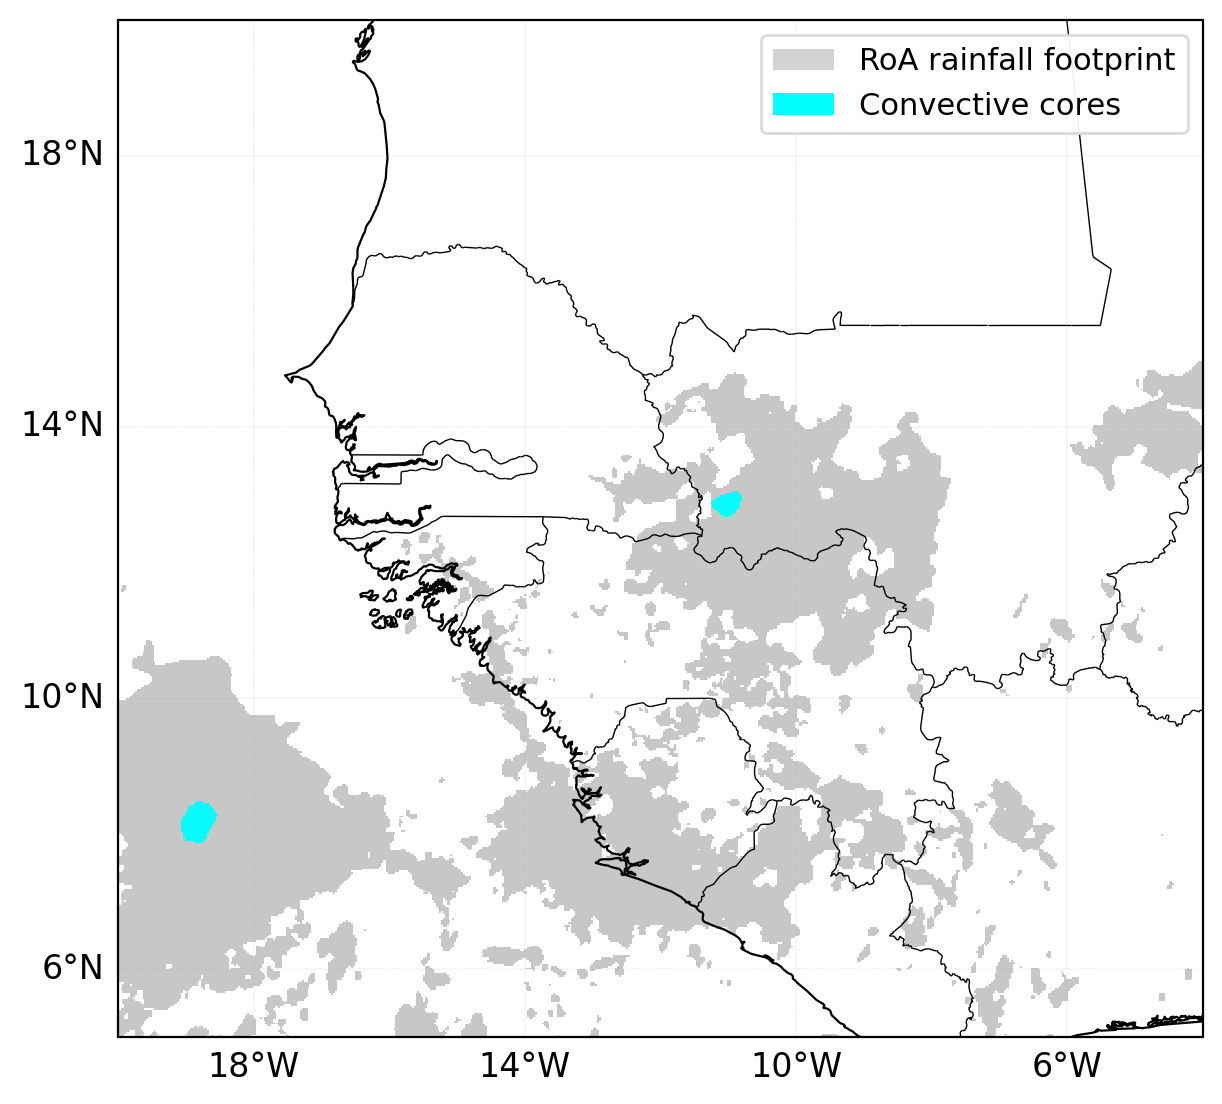

In [103]:
mask_roa  = np.where(data_roa > 0, 1, np.nan)
mask_core = np.where(data_core_interp > 0, 1, np.nan)

proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(7, 7), dpi=200)
ax = plt.axes(projection=proj)

ax.coastlines(resolution="10m", linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)

ax.set_extent(
    [CONTEXT_LON_MIN, CONTEXT_LON_MAX,
     CONTEXT_LAT_MIN, CONTEXT_LAT_MAX],
    crs=proj
)

gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.1,
                  xlocs=np.arange(-18, 6, 4),
                  ylocs=np.arange(6, 20, 4))

gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {"size": 12}
gl.ylabel_style = {"size": 12}


# RoA rainfall footprint
ax.pcolormesh(
    lons_common,
    lats_common,
    mask_roa,
    shading="nearest",
    cmap=ListedColormap(["#c7c7c7"]),
    alpha=1,
    transform=proj
)

# Convective cores
ax.pcolormesh(
    lons_common,
    lats_common,
    mask_core,
    shading="nearest",
    cmap=ListedColormap(["cyan"]),
    alpha=0.95,
    transform=proj
)

legend_elements = [
    Patch(facecolor="lightgrey", edgecolor="none", label="RoA rainfall footprint"),
    Patch(facecolor="cyan", edgecolor="none", label="Convective cores"),
]

ax.legend(
    handles=legend_elements,
    loc="upper right",
    framealpha=0.95,
    edgecolor="0.85",
    fontsize=11
)

plt.show()

# Applying some filter

In [121]:
# Apply spatial max filter (e.g. 3x3 or 5x5)
kernel_size = 27   # try 3, 5, 7 etc

data_core_smooth = maximum_filter(
    data_core_interp,
    size=kernel_size
)

print("Max filter applied with kernel size:", kernel_size)


Max filter applied with kernel size: 27


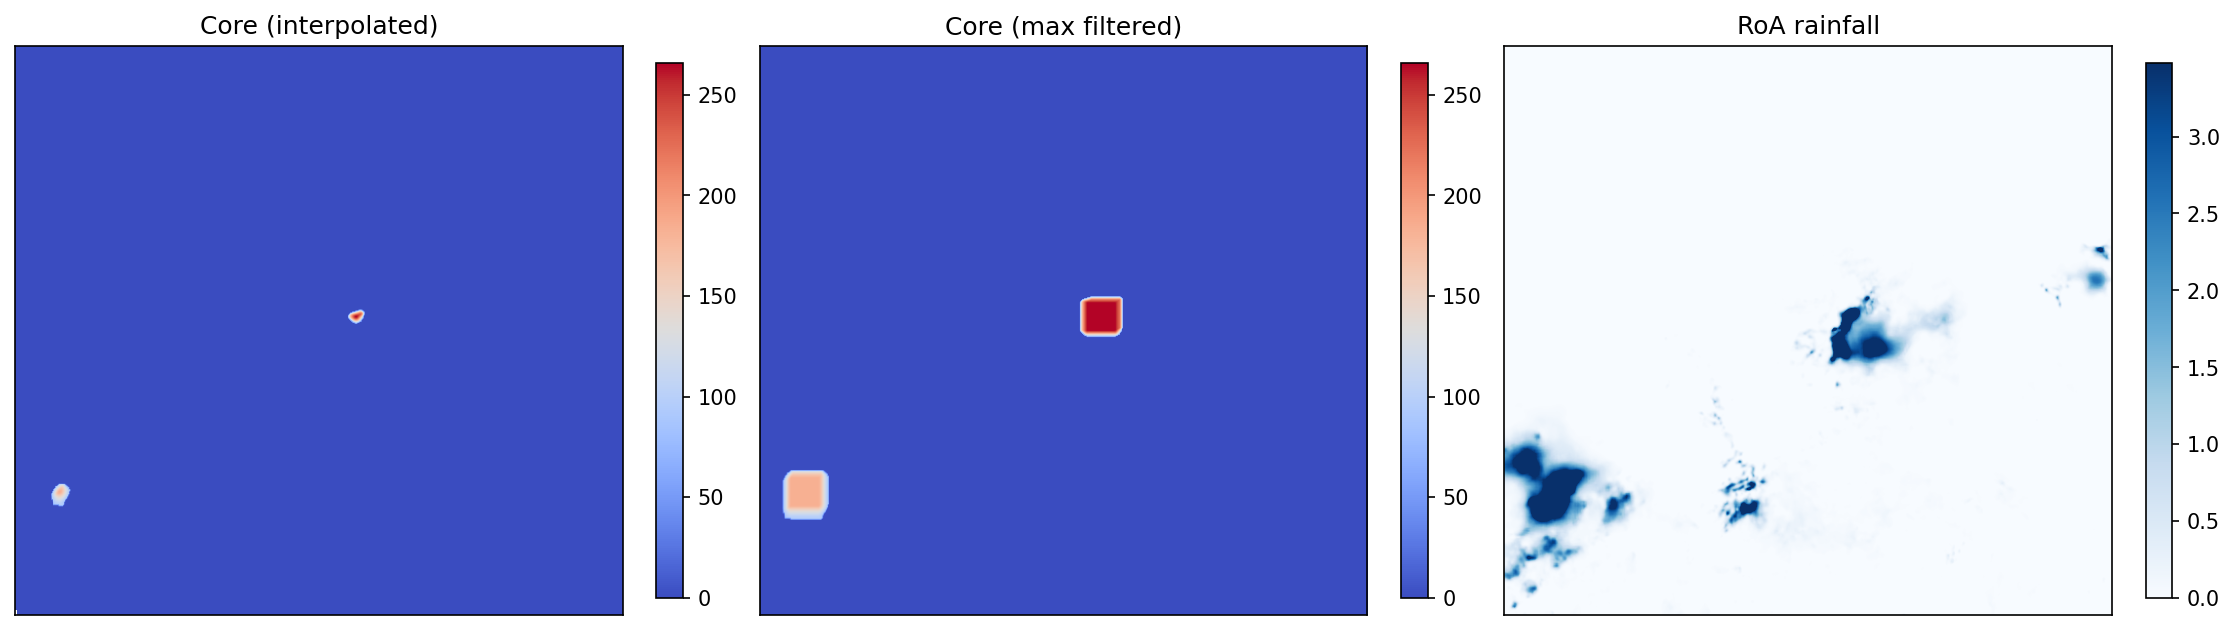

In [124]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), dpi=150)

# Core interpolated
im0 = axes[0].imshow(
    data_core_interp,
    origin="lower",
    cmap="coolwarm"
)
axes[0].set_title("Core (interpolated)")
plt.colorbar(im0, ax=axes[0], fraction=0.04)

# Core after max filter
im1 = axes[1].imshow(
    data_core_smooth,
    origin="lower",
    cmap="coolwarm"
)
axes[1].set_title("Core (max filtered)")
plt.colorbar(im1, ax=axes[1], fraction=0.04)

# RoA rainfall
# Use percentile scaling to avoid flat blue image
vmax = np.nanpercentile(data_roa, 99)

im2 = axes[2].imshow(
    data_roa,
    origin="lower",
    cmap="Blues",
    vmin=0,
    vmax=vmax
)
axes[2].set_title("RoA rainfall")
plt.colorbar(im2, ax=axes[2], fraction=0.04)

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()